# Advanced Computer Vision - Week_01 - SIFT (Scale-Invariant Feature Transform)
SIFT is a computer vision algorithm used for detecting and describing local features in images. These features are invariant to changes in scale, rotation, illumination, and viewpoint, making SIFT a powerful tool for tasks such as object recognition, image stitching, and image retrieval.

The SIFT algorithm works by identifying keypoints in an image, which are distinctive points that are invariant to various transformations. Then, it computes descriptors for these keypoints, which capture the local appearance and structure of the image around each keypoint. These descriptors are highly informative and can be used for matching and recognizing objects across different images.

SIFT has been widely used in various applications in computer vision and image processing due to its robustness and effectiveness in handling diverse image conditions. However, it's worth noting that SIFT is patented, which may limit its usage in some contexts.

In [90]:
# import packages
from  skimage import data, transform
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
import numpy as np
from scipy import signal
from scipy.ndimage import gaussian_filter
from scipy.ndimage import maximum_filter,minimum_filter
from skimage.morphology import binary_dilation,rectangle
from skimage.feature import hessian_matrix
# NOTE: OPEN FILE STRUCTURE NAVIGATOR

## 1. Scale-space extrema detection
- Scale space gaussian filtering
- Difference of gaussian
- Find scale space extremes (min, max)

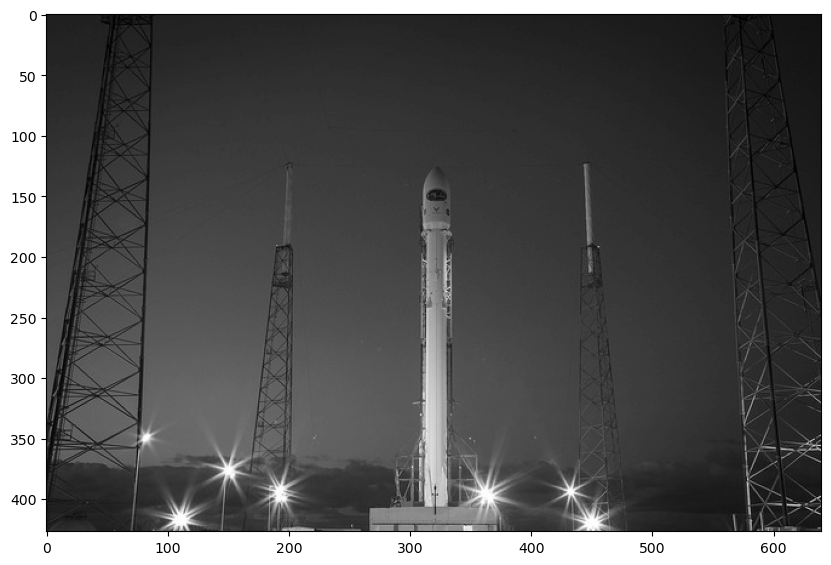

In [91]:
# load image -> rocket image only for demonstration
img_orig = data.rocket()
img  = rgb2gray(img_orig)
plt.figure(figsize=(10,10))
plt.imshow(img, cmap="gray")

### Scale space gaussian filtering
For gaussian filtering we use gaussian filter/kernel.

<br>

#### First method - manual
We need create gaussian filter. After created kernel apply 2D convolution for blurring image.
<img src="_materials/gauss_function_sigmas.png" width=500>

In [92]:
sigma_0 = 0.7
gauss_vector_0 = signal.gaussian(5, sigma_0)
# sigma = 30
# gauss_vector = signal.gaussian(100, sigma)
gauss_vector_0

# Create another signal for demonstrating difference of value distribution
sigma_1 = 5
gauss_vector_1 = signal.gaussian(5, sigma_1)
gauss_vector_1

print(gauss_vector_0)
print(gauss_vector_1)

[0.01687988 0.36044779 1.         0.36044779 0.01687988]
[0.92311635 0.98019867 1.         0.98019867 0.92311635]


In [93]:
kernel_manual_0 = np.outer(gauss_vector_0,gauss_vector_0)
kernel_manual_1 = np.outer(gauss_vector_1,gauss_vector_1)

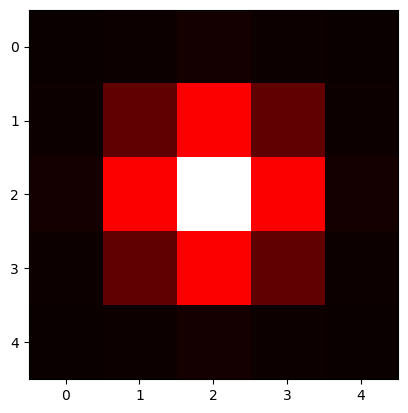

In [94]:
plt.imshow(kernel_manual_0)

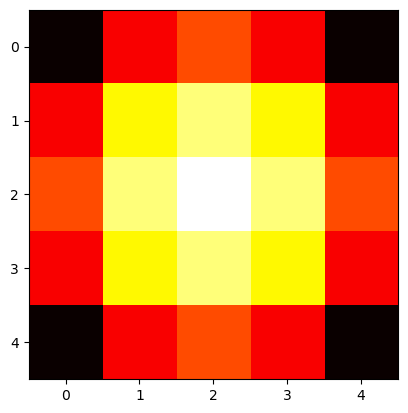

In [95]:
plt.imshow(kernel_manual_1)

In [96]:
# Apply convolution on original image for blurring
gauss_filt_img_0 = signal.convolve2d(img,kernel_manual_0)
gauss_filt_img_1 = signal.convolve2d(img,kernel_manual_1)

Text(0.5, 1.0, 'Gauss filt. img')

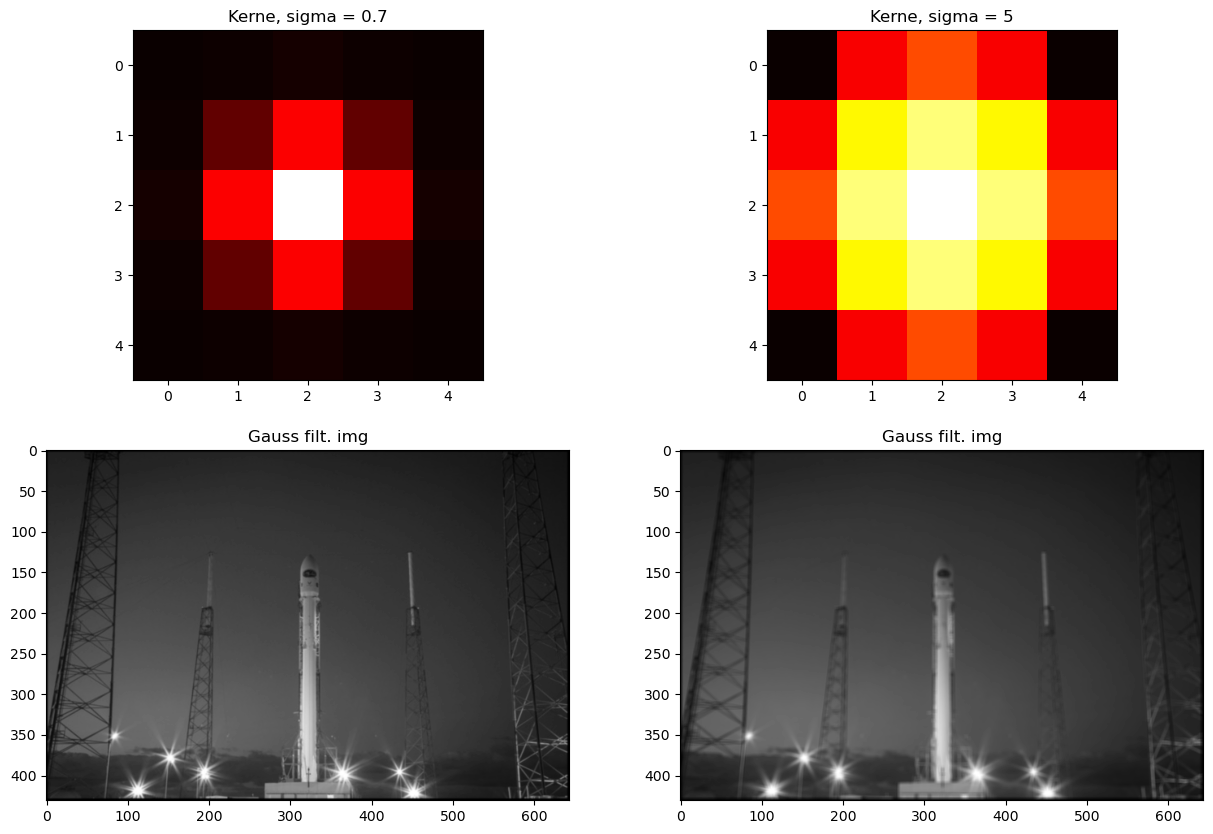

In [97]:
# show
plt.figure(figsize=(15,10))
plt.subplot(221)
plt.imshow(kernel_manual_0)
plt.title("Kerne, sigma = {value}".format(value=sigma_0))
plt.subplot(222)
plt.title("Kerne, sigma = {value}".format(value=sigma_1))
plt.imshow(kernel_manual_1)
plt.subplot(223)
plt.title("Gauss filt. img")
plt.imshow(gauss_filt_img_0, cmap="gray")
plt.subplot(224)
plt.imshow(gauss_filt_img_1, cmap="gray")
plt.title("Gauss filt. img")

#### Second method - from scipy.ndimage import gaussian_filter

Text(0.5, 1.0, 'Gauss filter img, sigma = 5')

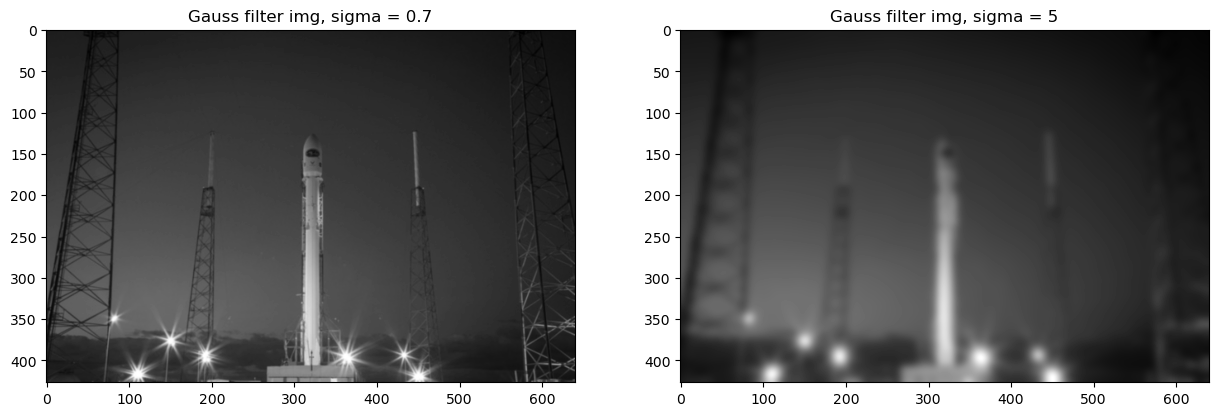

In [98]:
plt.figure(figsize=(15,10))
plt.subplot(121)
plt.title("Gauss filter img, sigma = {value}".format(value=sigma_0))
plt.imshow(gaussian_filter(img,sigma_0), cmap="gray")
plt.subplot(122)
plt.imshow(gaussian_filter(img,sigma_1), cmap="gray")
plt.title("Gauss filter img, sigma = {value}".format(value=sigma_1))

#### Create scale space
The SIFT algorithm requires the creation of a scale space, which involves applying Gaussian blurring to the input image at different scales. The 'sigmas' list contains predefined sigma values corresponding to the desired scales for the scale space. We initialize an ndarray called 'scale_space_array' to store the blurred images at different scales. The array dimensions match the input image's dimensions. Gaussian filtering is applied to the input image using each sigma value, producing a series of blurred images representing different scales. The resulting scale space is visualized using matplotlib subplots.

Creating a scale space in the SIFT (Scale-Invariant Feature Transform) algorithm is essential for achieving scale invariance, which is a crucial property for robust feature detection and matching across different scales in images. Here's why creating a scale space is necessary in SIFT:
**Scale Invariance:** Objects in images can appear at different scales due to variations in distance, viewpoint, and imaging conditions. To detect and describe features invariantly to scale changes, the SIFT algorithm constructs a scale space by generating blurred versions of the input image at different scales. This allows SIFT to identify features regardless of their size or scale within the image.
**Multi-scale Feature Detection:** Features such as corners, edges, or blobs may have different scales depending on their size and prominence in the image. By constructing a scale space with a range of blurring levels (controlled by different sigma values in Gaussian filtering), SIFT ensures that features are detected at multiple scales. This multi-scale approach increases the likelihood of detecting features accurately and reliably.
**Keypoint Localization:** Keypoint localization in SIFT involves identifying stable and distinctive points in the scale space. These keypoints correspond to areas with significant intensity changes across scales, making them robust features for matching. By analyzing differences in intensity between adjacent scales (e.g., computing the Difference of Gaussians), SIFT can accurately localize keypoints and determine their scale-invariant properties.
**Descriptor Generation:** After identifying keypoints, SIFT generates descriptors to describe the local appearance and structure of each keypoint region. These descriptors are computed based on gradient orientations within the region and are invariant to scale, rotation, and illumination changes. The scale information obtained from the scale space is crucial for generating scale-invariant descriptors, ensuring accurate matching of keypoints across different images.

Text(0.5, 0.98, 'Scale space in one Octave')

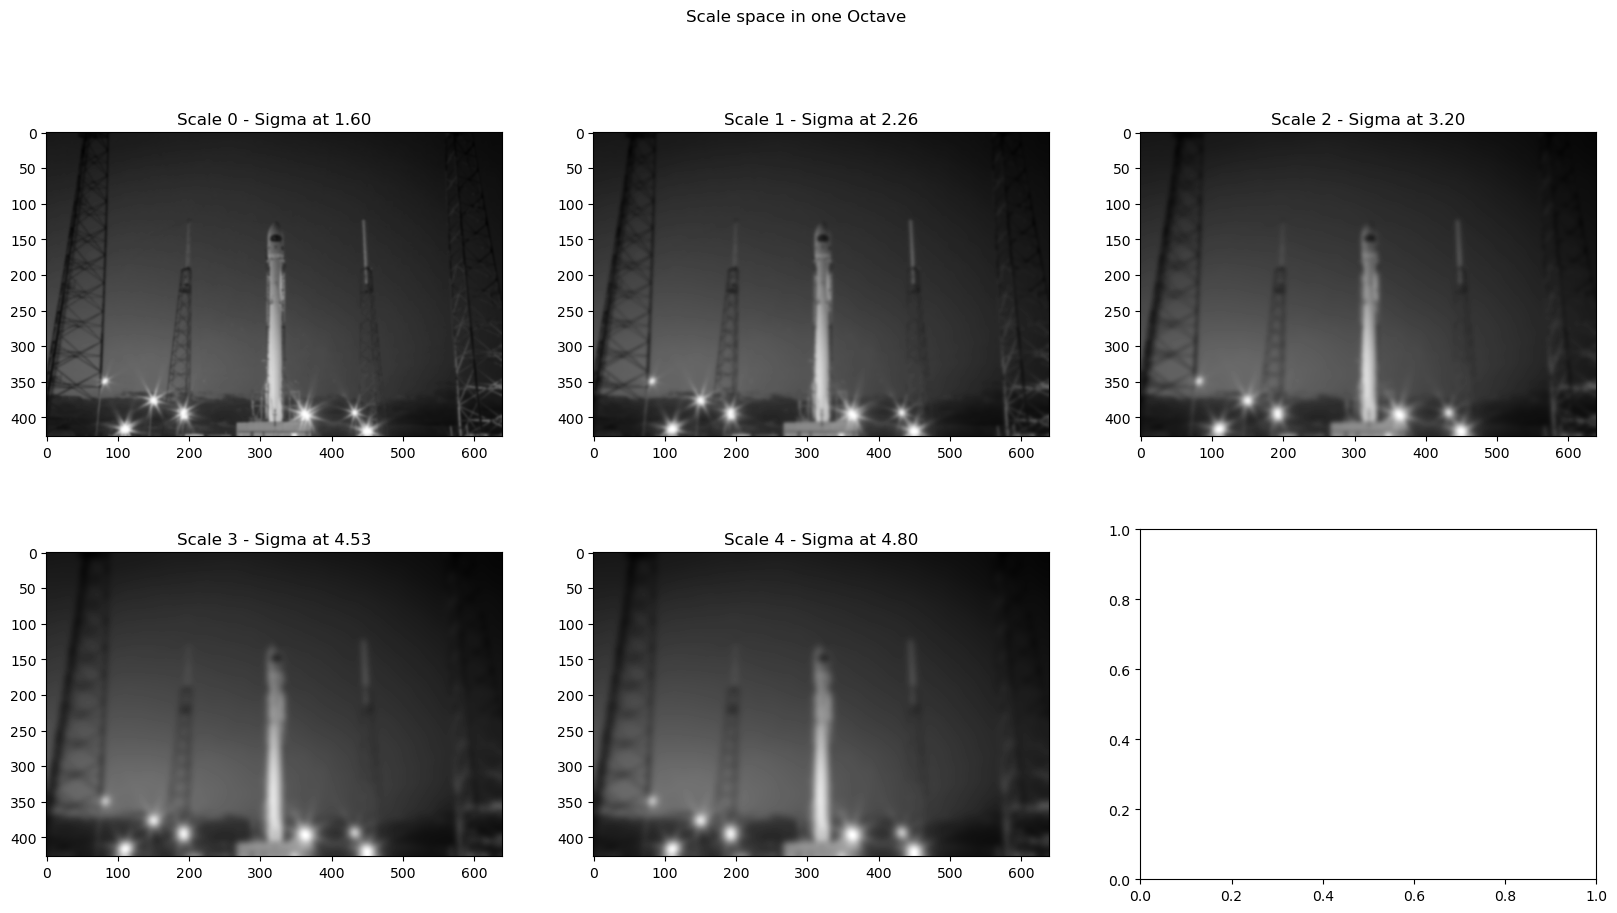

In [99]:
# Define sigmas for scale space
sigmas = [np.sqrt(2)/2,  # Sigma for the first octave
          1,             # Sigma for the second octave
          np.sqrt(2),    # Sigma for the third octave
          2,             # Sigma for the fourth octave
          2*np.sqrt(2),  # Sigma for the fifth octave
          2*2]           # Sigma for the sixth octave


sigmas = [1.6,  np.sqrt(2)*1.6, 2*1.6, np.sqrt(2)*2*1.6, 3*1.6]

# Prepare ndarray for scale space
# The scale space array will have the same dimensions as the input image,
# but will store blurred versions of the image at different scales
scale_space_array = np.zeros(shape=(img.shape[0], img.shape[1], len(sigmas)))

# Create scale space
for i, sigma in enumerate(sigmas):
    # Apply Gaussian filtering to the input image with the current sigma value
    scale_space_array[:, :, i] = gaussian_filter(img, sigma)

# Visualize scale space
fig, axs = plt.subplots(2, 3, figsize=(20, 10))
for i, sigma in enumerate(sigmas):
    # Plot each scale space image in a subplot
    axs[i//3, i%3].imshow(scale_space_array[:, :, i], cmap="gray")
    axs[i//3, i%3].set_title("Scale {} - Sigma at {:.2f}".format(i, sigma))
plt.suptitle("Scale space in one Octave")

### DoG - Difference of gaussians

The Difference of Gaussians (DoG) is a crucial step in the Scale-Invariant Feature Transform (SIFT) algorithm, aimed at detecting and describing local features in images. DoG involves subtracting adjacent blurred images from the scale space array. First, a series of blurred images are generated at different scales using Gaussian filtering. Then, the DoG is computed by subtracting each pair of adjacent blurred images. The resulting DoG images highlight regions with significant intensity changes across different scales, providing valuable information for feature detection and description.

DoG computation is essential in identifying potential keypoints where features are present.
Peaks in the DoG images indicate areas of significant intensity variation, often corresponding to distinctive features.
Visualizing the DoG helps in identifying candidate keypoints for further processing, such as feature matching and object recognition.
Adjusting the sigma values used for Gaussian blurring affects the scale at which features are detected, impacting the appearance of the DoG images and the subsequent feature extraction process.

Text(0.5, 0.98, 'DoGs in one Octave')

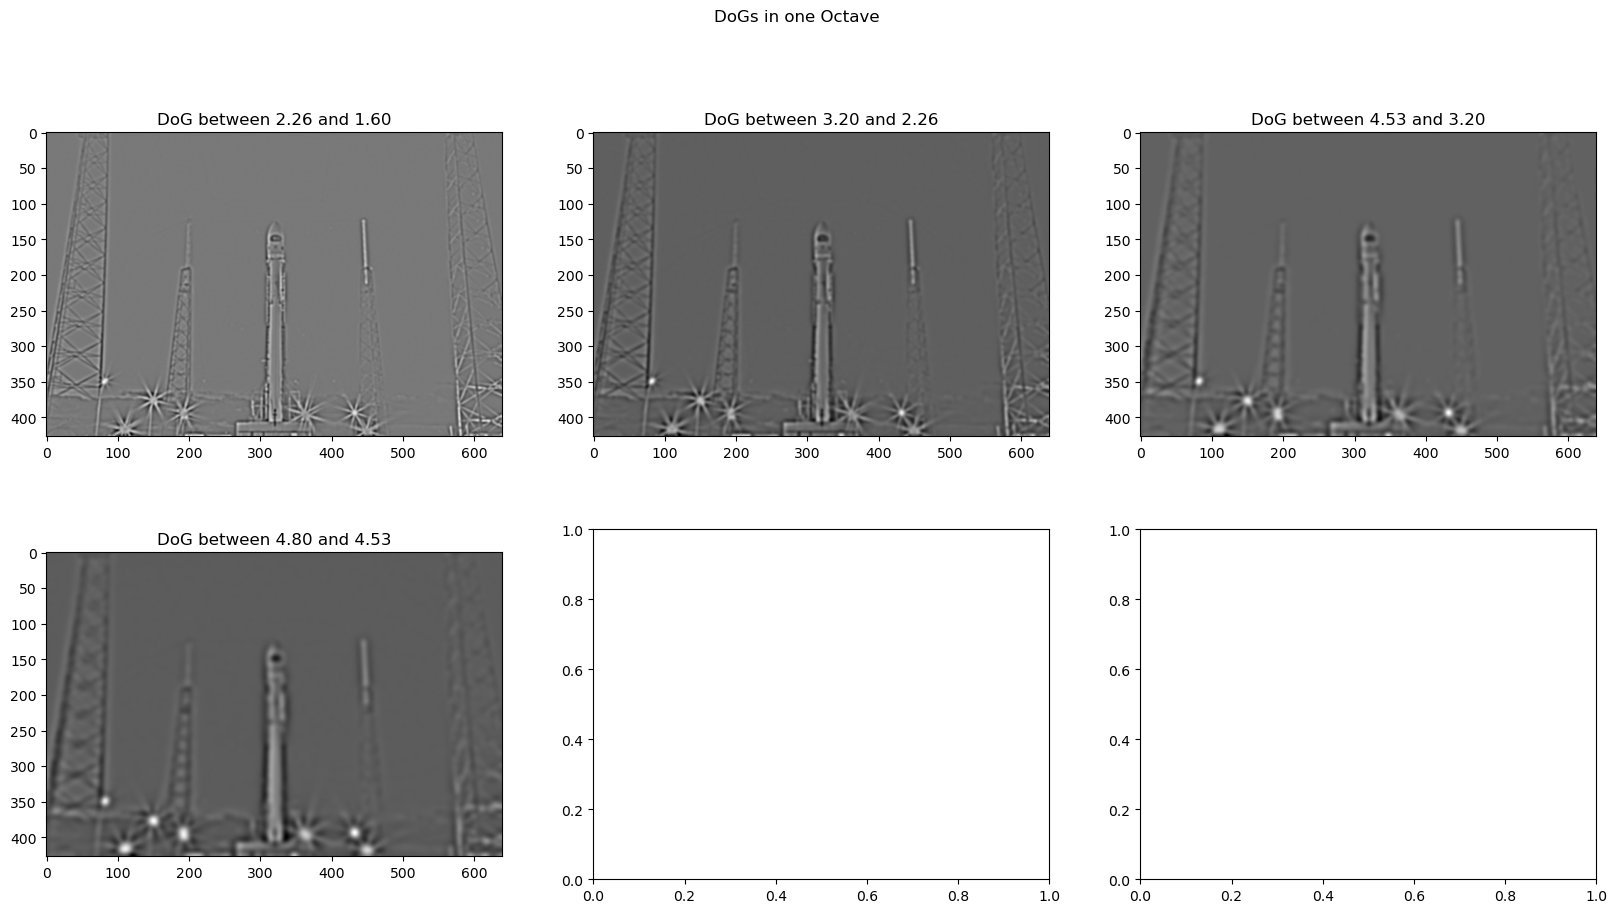

In [100]:
# Compute Difference of Gaussians (DoG)
dog_array = np.zeros_like(scale_space_array)
for i in range(dog_array.shape[2] - 1):
    dog_array[:, :, i] = scale_space_array[:, :, i] - scale_space_array[:, :, i+1]

# Visualize DoG images
fig, axs = plt.subplots(2, 3, figsize=(20, 10))
for i in range(dog_array.shape[2] - 1):
    axs[i // 3, i % 3].imshow(dog_array[:, :, i], cmap="gray")
    axs[i // 3, i % 3].set_title("DoG between {:.2f} and {:.2f}".format(sigmas[i+1], sigmas[i]))
plt.suptitle("DoGs in one Octave")


# Description:
# - The Difference of Gaussians (DoG) is computed by subtracting adjacent
#   blurred images from the scale space array.
# - 'dog_images' is an ndarray created to store the DoG images.
# - The loop iterates over adjacent sigma values in the 'sigmas' list,
#   subtracting each pair of blurred images to compute the DoG images.
# - The resulting DoG images represent the difference in scale between adjacent
#   levels in the scale space, highlighting features with significant intensity changes.



# Comments:
# - DoG highlights regions with significant intensity changes across different scales.
# - Peaks in the DoG images correspond to potential keypoint locations where features are detected.
# - Visualizing the DoG helps in identifying candidate keypoints for further processing.
# - Adjusting the sigma values impacts the scale at which features are detected,
#   affecting the appearance of the DoG images.


### Find extremes between dogs
The use of multidimensional finding of extrema in the Difference of Gaussians (DoG) images is crucial in the SIFT (Scale-Invariant Feature Transform) algorithm for several reasons:

**Scale-space Representation:** The DoG images represent the scale-space representation of the original image. In the scale space, features may appear at different scales due to variations in object size, viewpoint, and imaging conditions. Multidimensional finding of extrema ensures that potential keypoints are detected across multiple scales, allowing for scale-invariant feature detection.

**Robustness to Noise and Scale Changes:** Multidimensional finding of extrema helps in identifying stable and distinctive keypoints even in the presence of noise and variations in scale. By considering both spatial and scale dimensions, SIFT ensures that keypoints are detected at locations where the image structure is significantly different from the surrounding areas across multiple scales.

**Scale-Invariant Feature Description:** After detecting keypoints at multiple scales, SIFT constructs scale-invariant descriptors to describe the local appearance of each keypoint region. These descriptors are computed based on the gradients of image intensity within a spatial neighborhood around each keypoint. Multidimensional finding of extrema ensures that keypoints are detected at appropriate scales, facilitating accurate descriptor computation and robust feature matching.


<Figure size 3000x3000 with 0 Axes>

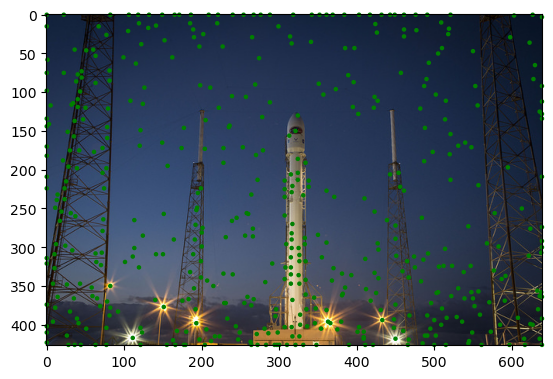

In [101]:
# Suppress scientific notation for readability
np.set_printoptions(suppress=True)

# Apply maximum and minimum filters to find local maxima and minima in DoG images
dog_max_filt = maximum_filter(dog_array, (3, 3, 3))
dog_min_filt = minimum_filter(dog_array, (3, 3, 3))

# Identify local maxima and minima positions
local_max = (dog_array == dog_max_filt)
local_min = (dog_array == dog_min_filt)

# Mark keypoints where local maxima or minima exist in at least one adjacent DoG image
keypoints = np.logical_or(np.sum(local_max[:, :, 1:4], axis=2) > 0, np.sum(local_min[:, :, 1:4], axis=2) > 0)

# Count the total number of keypoints detected
total_keypoints = np.sum(np.sum(keypoints))

# Plot keypoints on the original image
plt.figure(figsize=(30, 30))
fig, ax = plt.subplots()
rr, cc = np.where(keypoints)
ax.imshow(img_orig)
for r, c in zip(rr, cc):
    circle1 = plt.Circle((c, r), 2, color='g', clip_on=False)
    ax.add_patch(circle1)

Enclose all to class for preventing panic attack

In [102]:
from sift import Sift
sift = Sift(img)

In [103]:
sift.sigmas_array

[1.6, 2.2627416997969525, 3.2, 4.525483399593905, 4.800000000000001]

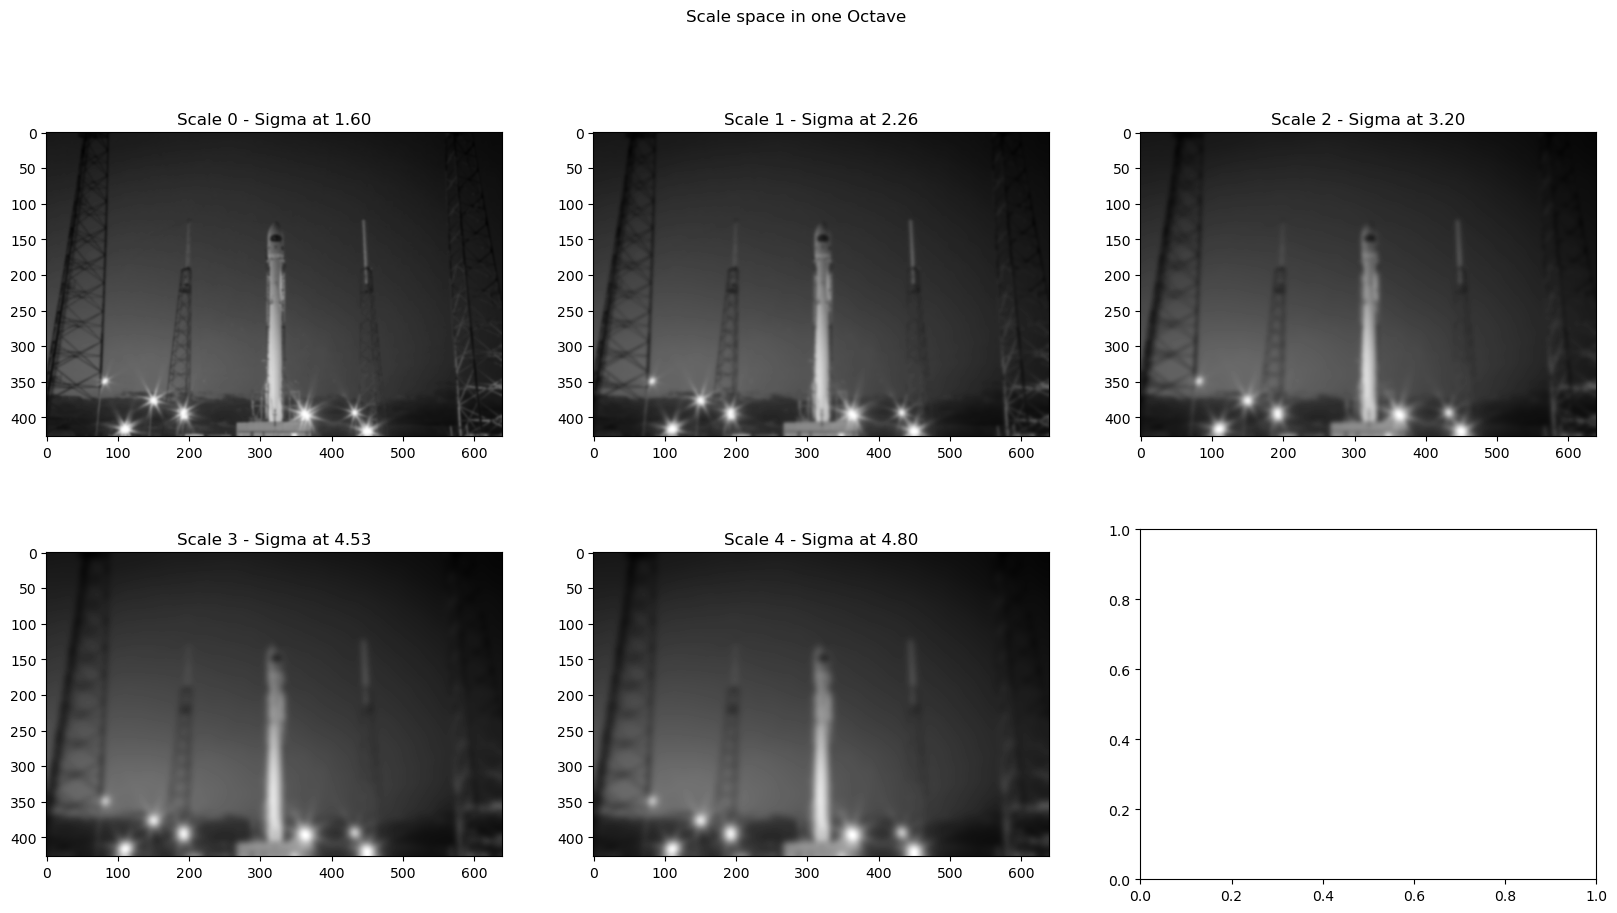

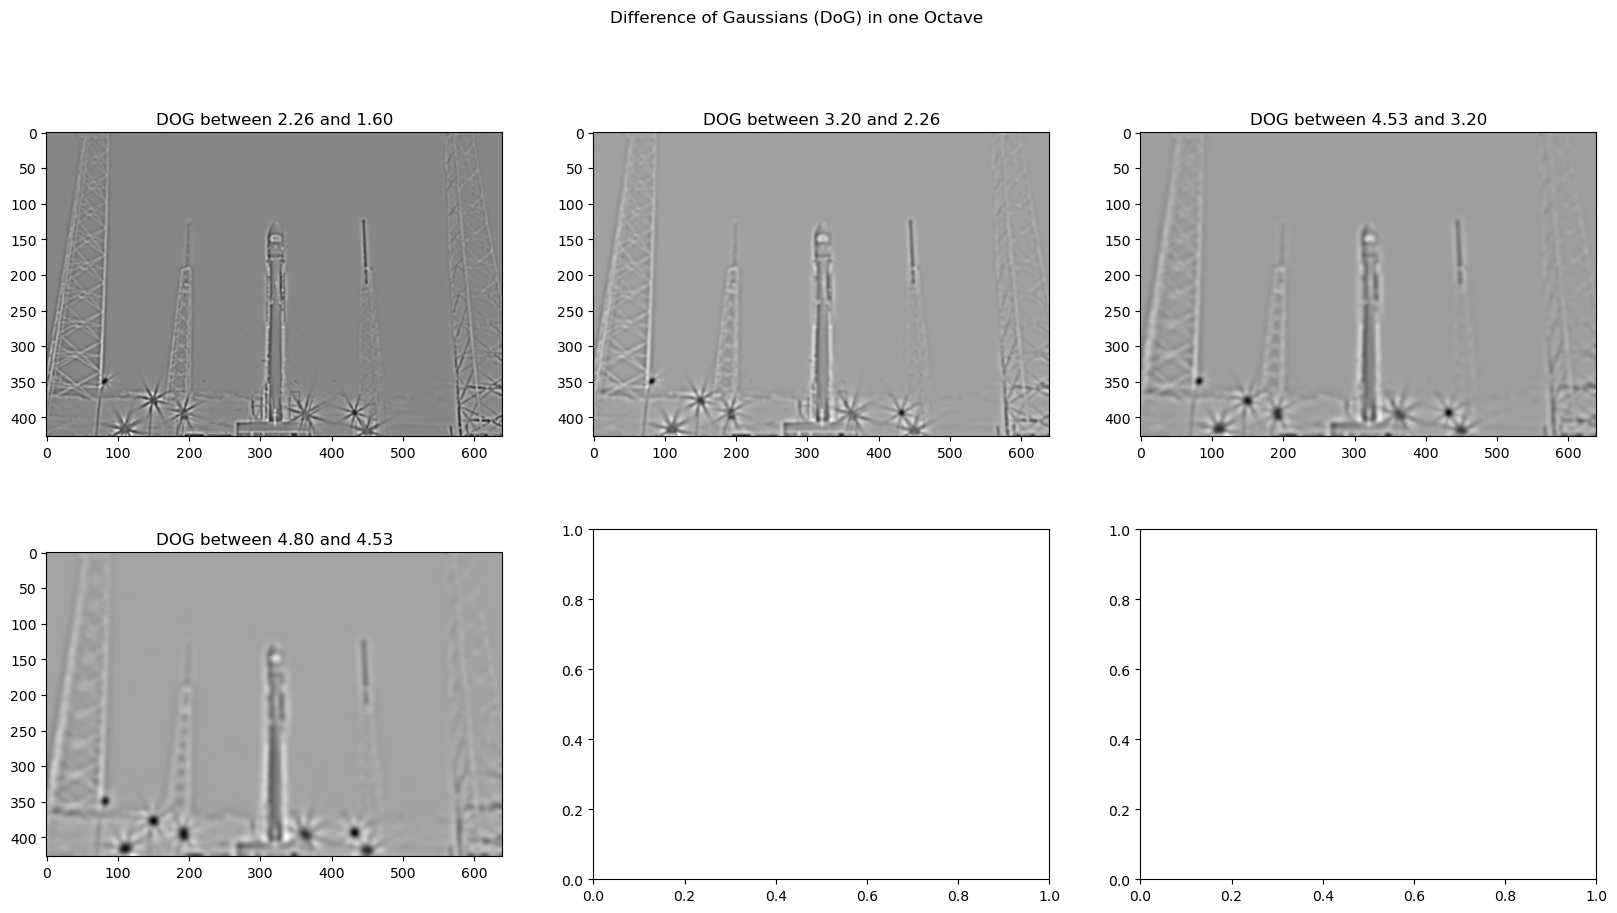

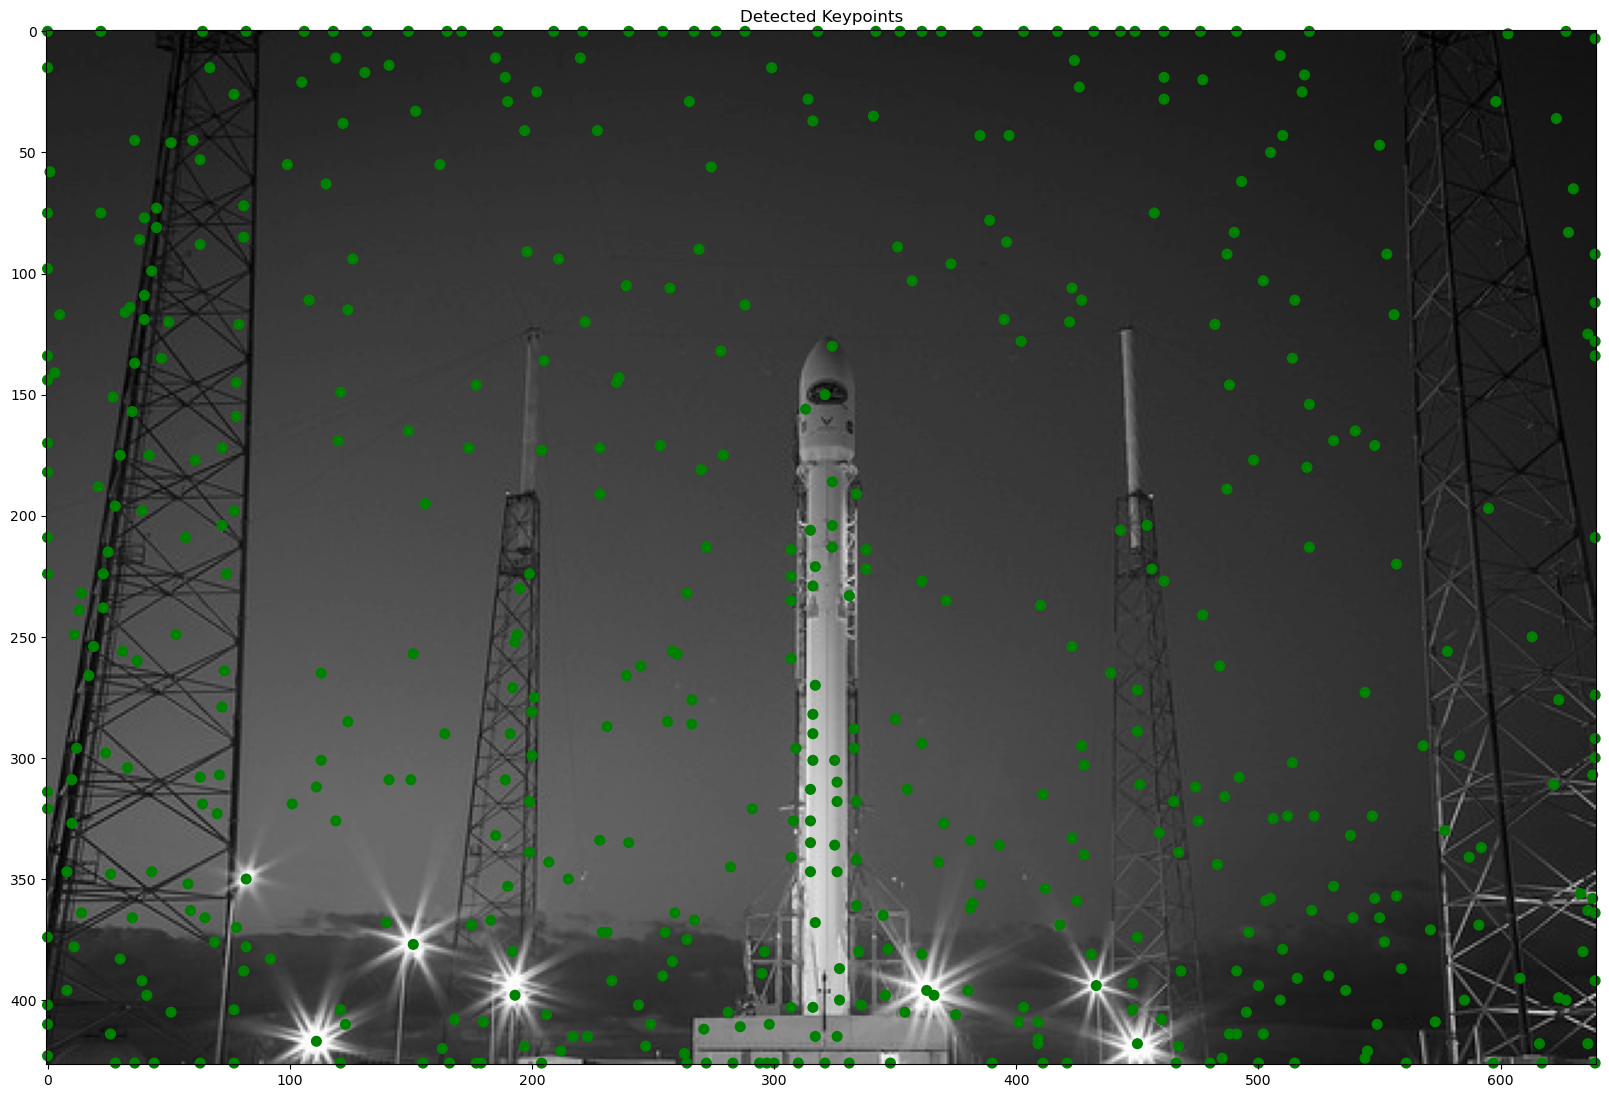

Number of keypoints candidates: 517


In [104]:
sift.octave_processing(image=sift.image, octave_scale_multiplier=1, sigmas=sift.sigmas_array, visualization=True)

## Create different octaves
In the context of the SIFT (Scale-Invariant Feature Transform) algorithm, an octave refers to a set of images obtained by repeatedly downsampling the original image by a factor of 2. Each octave contains a series of images at different scales, where each scale is achieved by applying Gaussian blurring to the original image.

Image Pyramid: The process of creating an octave starts with the original input image. This image is then repeatedly downsampled by a factor of 2 to produce a series of images, forming what is known as an image pyramid. Each level of the pyramid represents a different scale of the original image.

In summary, an octave in the SIFT algorithm represents a set of images obtained by downsampling the original image and applying Gaussian blurring at different scales. Octaves play a crucial role in the multi-scale analysis of images, facilitating scale-invariant feature detection and robust matching in computer vision applications.

In [105]:
sift.octave_processing(image=sift.image, octave_scale_multiplier=2, sigmas=sift.sigmas_array, visualization=False)
sift.octave_processing(image=sift.image, octave_scale_multiplier=0.5, sigmas=sift.sigmas_array, visualization=False)
sift.octave_processing(image=sift.image, octave_scale_multiplier=0.25, sigmas=sift.sigmas_array, visualization=False)

Number of keypoints candidates: 850
Number of keypoints candidates: 808
Number of keypoints candidates: 1024


In [106]:
# Storing if keypoins for each octave separately, overlay original image
print(len(sift.octave_keypoints_global_array))
print(sift.octave_keypoints_global_array[0].shape)

4
(427, 640)


## Filtering
(Return to only one octave for demonstration)
Again we need select more detailed and specific keypoints

### Image Edge/border filtering
Keypoint detection algorithms often rely on identifying significant changes in image intensity, such as peaks in the gradient magnitude. Edges typically exhibit high gradient magnitudes, making them potential locations for keypoints. Points around edge/border are not interesting for key-key matching.

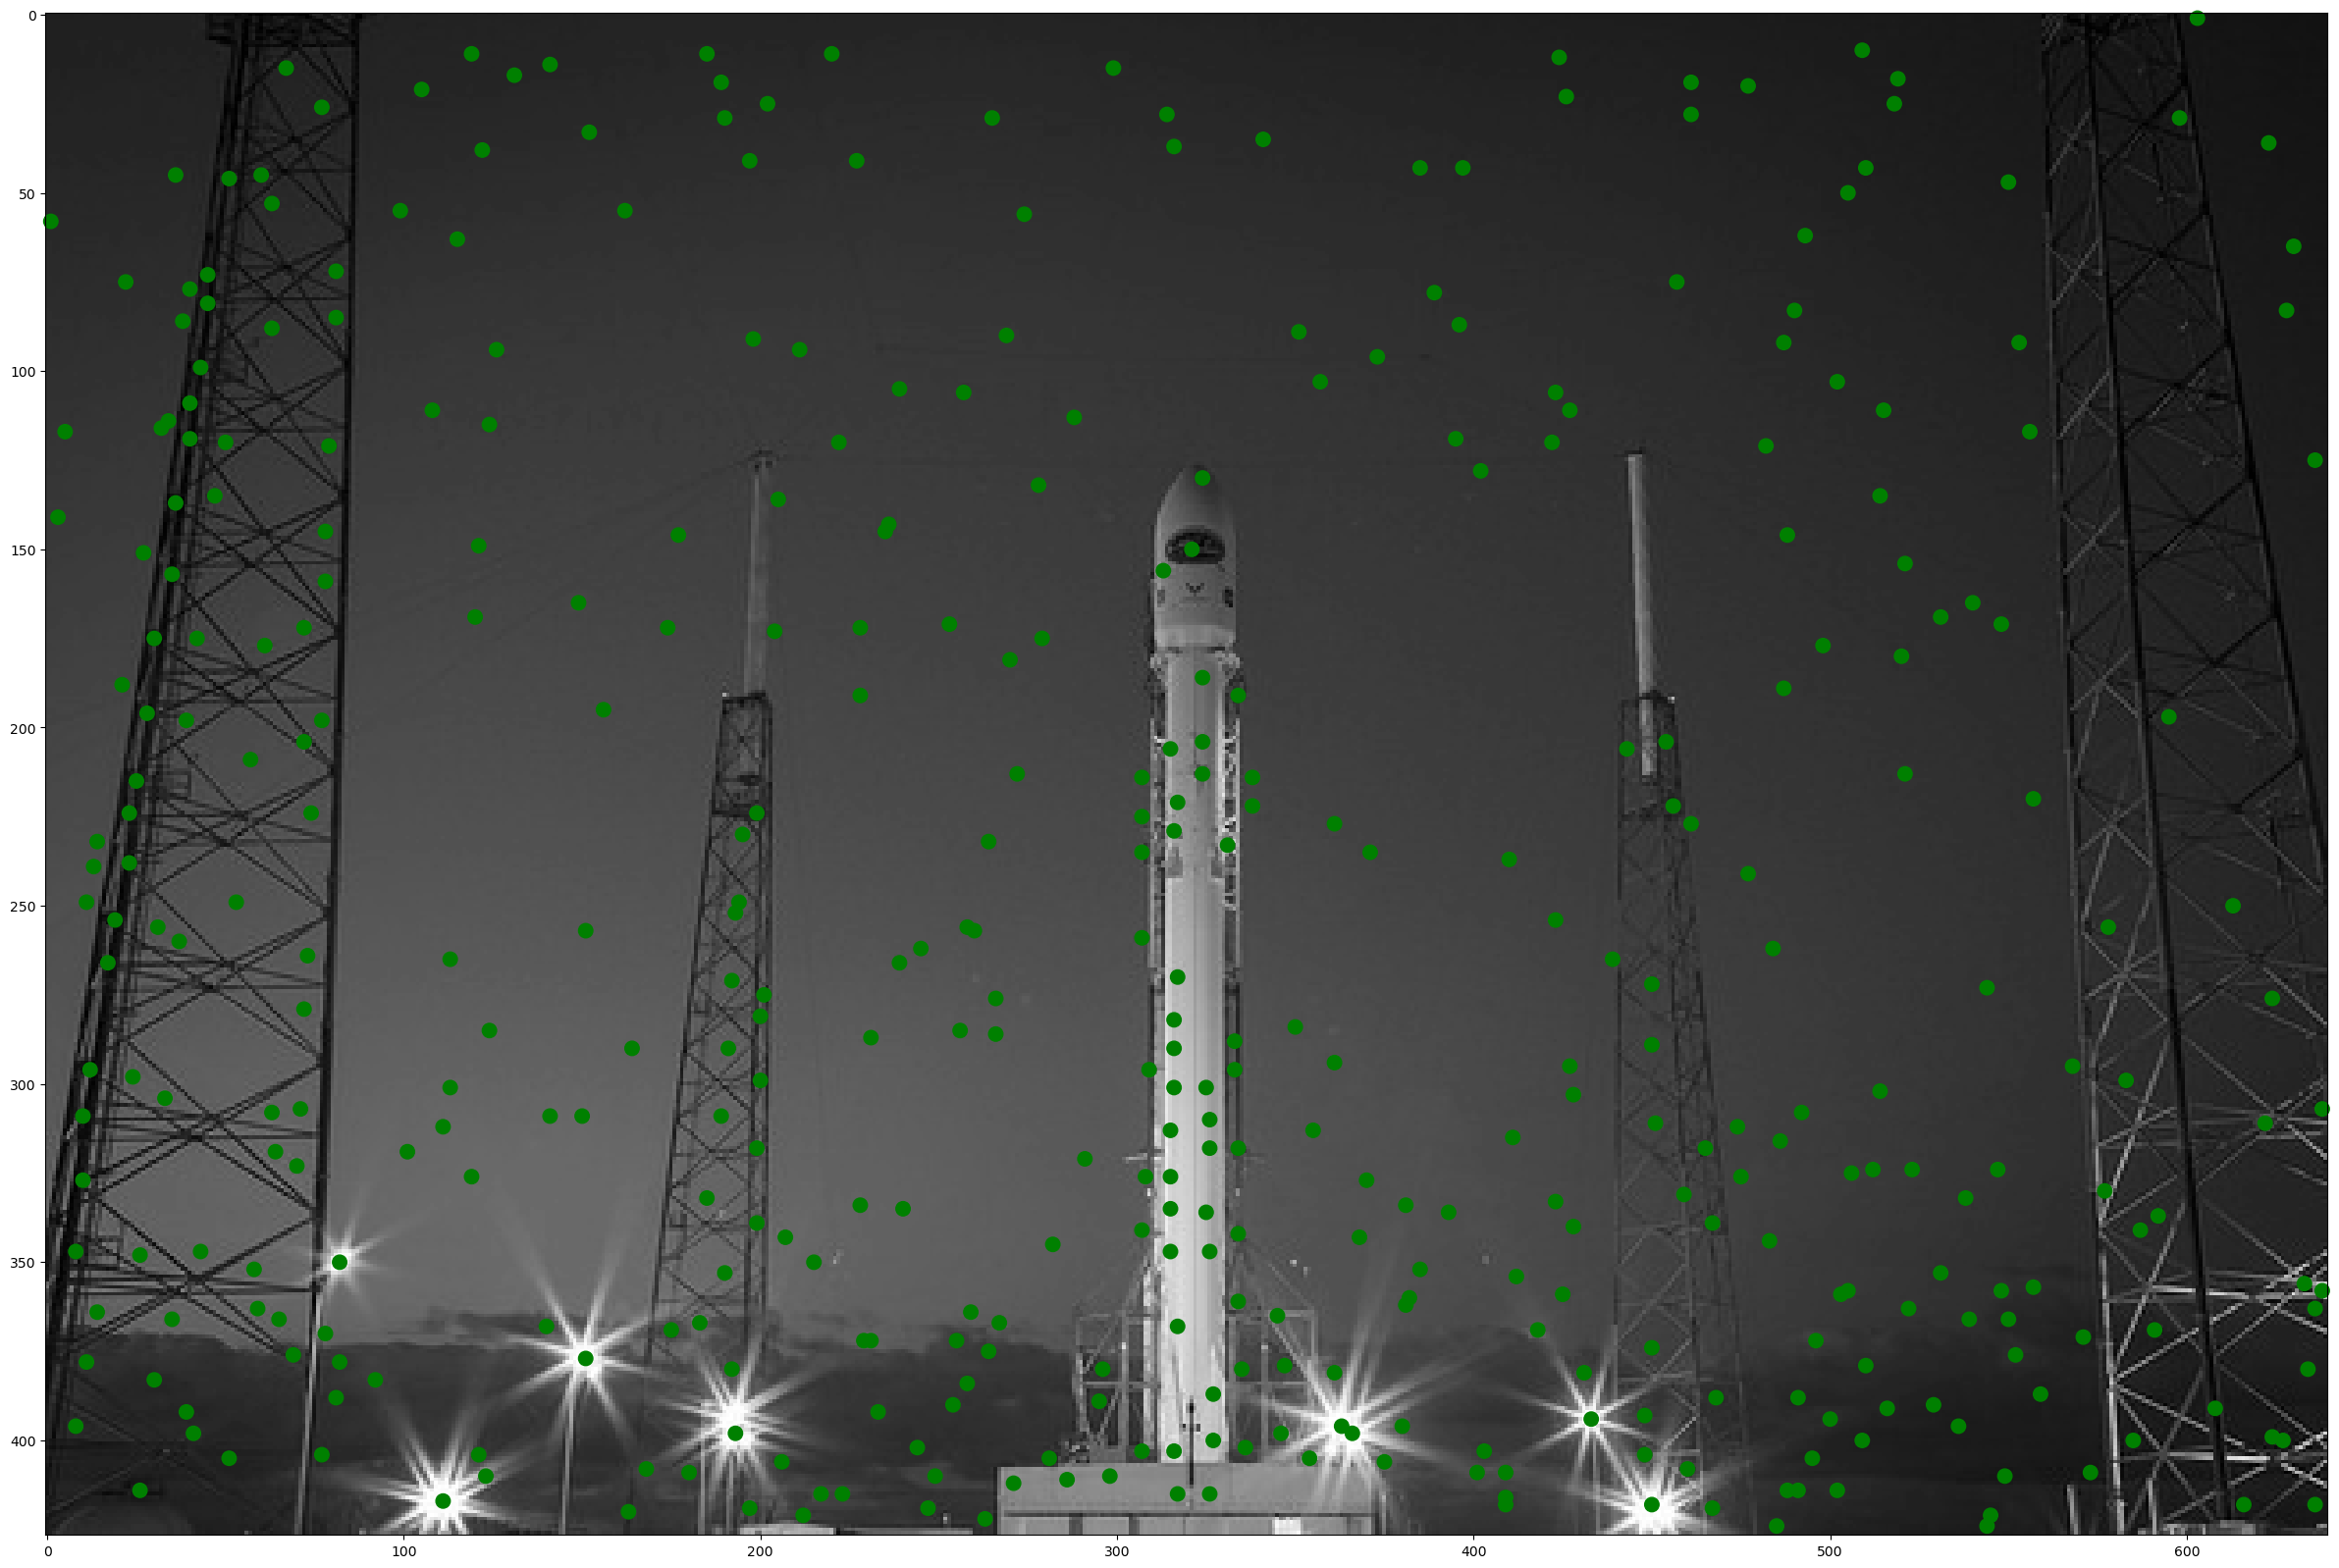

In [107]:
mask_after_edge_filtering = sift.key_point_filter_image_frame(img_shape=img.shape)


fig, ax = plt.subplots(figsize=(30,30))
rr, cc = np.where(sift.octave_keypoints_global_array[0] *
                  mask_after_edge_filtering)
ax.imshow(img, cmap="gray")
for r,c in zip(rr,cc):
    circle1 = plt.Circle((c, r), 2, color='g', clip_on=False)
    ax.add_patch(circle1)

### Low contrast filtering

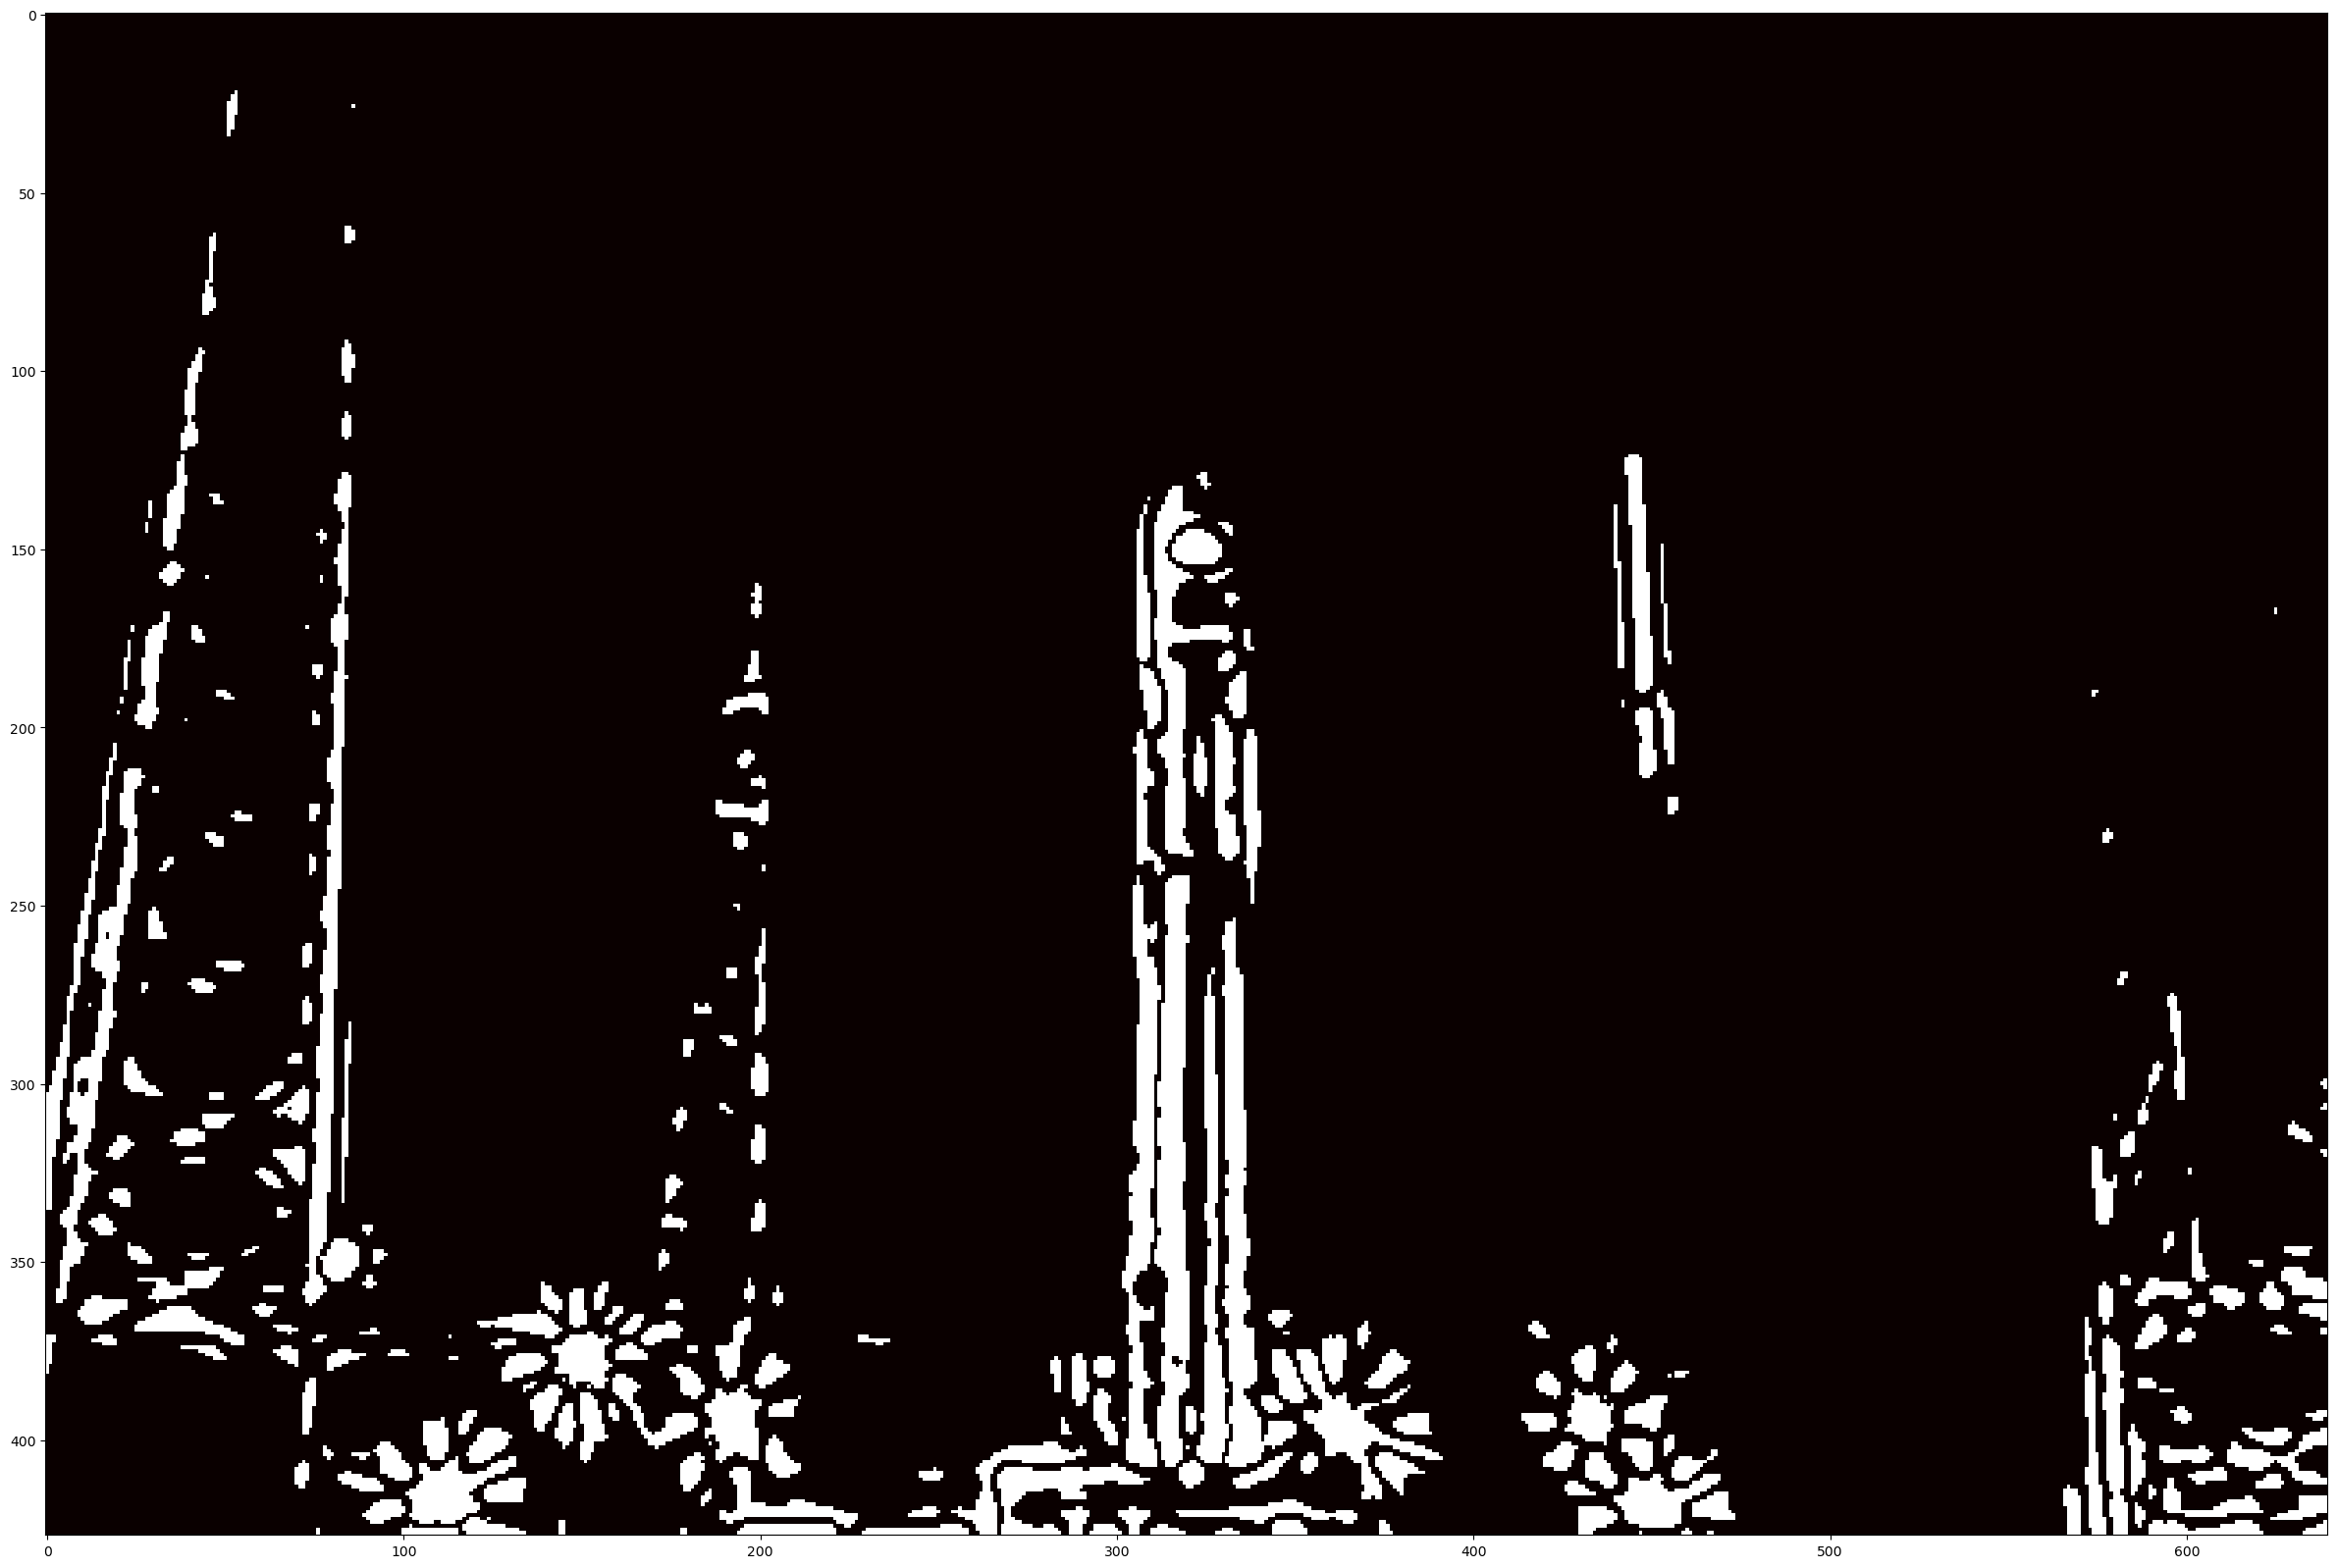

In [108]:
plt.figure(figsize=(30,30))
mask_after_low_contrast_filtering = sift.key_point_filter_contrast(sift.dog_global_array[0],0.01)
plt.imshow(mask_after_low_contrast_filtering)

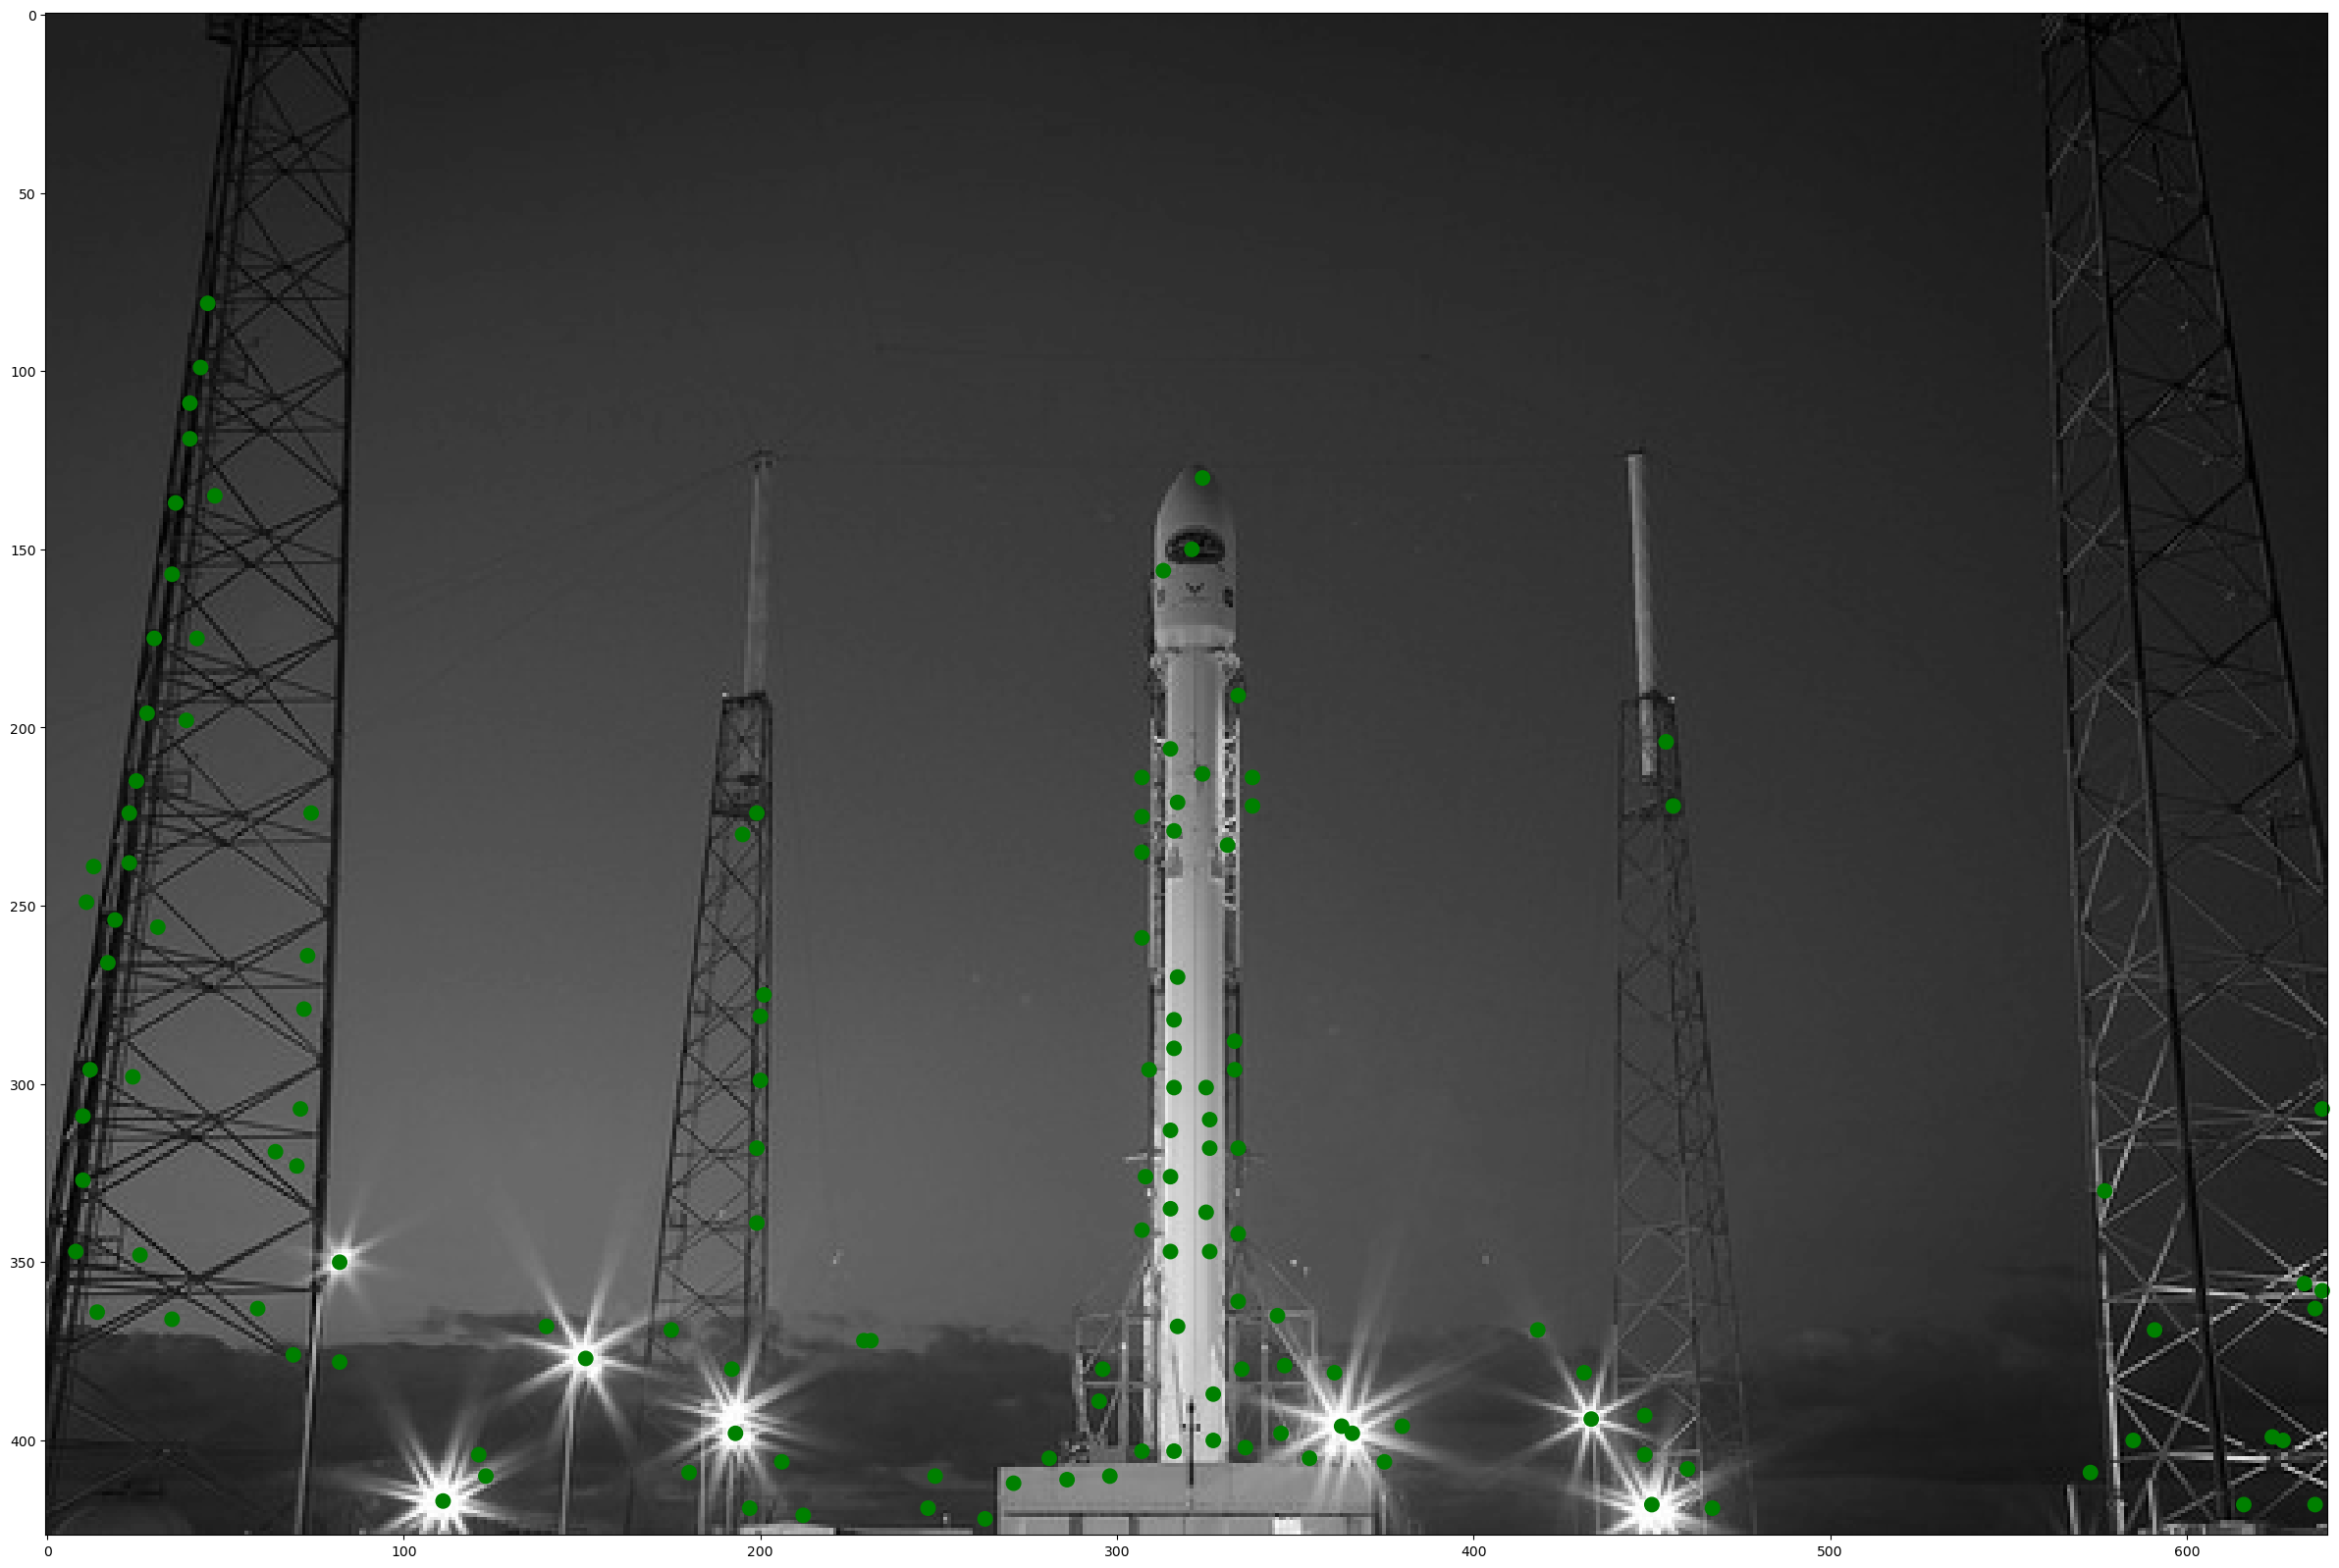

In [109]:
fig, ax = plt.subplots(figsize=(30,30))
rr, cc = np.where(sift.octave_keypoints_global_array[0] *
                  sift.key_point_filter_image_frame(img_shape=img.shape) *
                  mask_after_low_contrast_filtering)
ax.imshow(img, cmap="gray")
for r,c in zip(rr,cc):
    circle1 = plt.Circle((c, r), 2, color='g', clip_on=False)
    ax.add_patch(circle1)

### Filtering key-points on edges (Eliminating edge responses)
For stability, it is not sufficient to reject keypoints with low contrast. The difference of Gaussian function will have a strong response along edges, even if the location along the edge is poorly determined and therefore unstable to small amounts of noise.


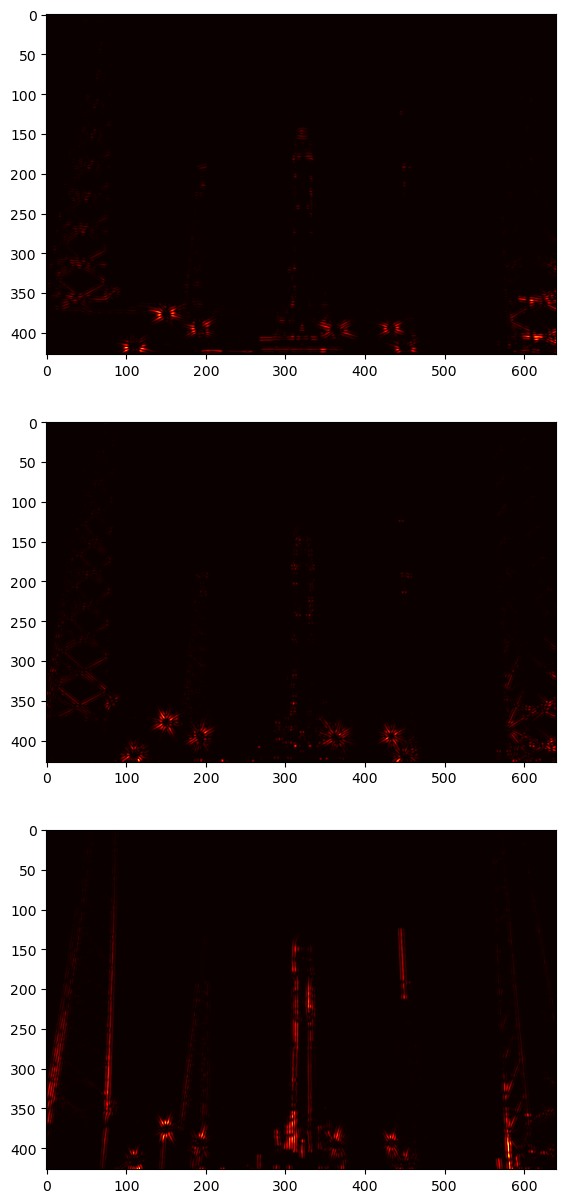

In [110]:
# Calculate Hessian matrix components (second-order partial derivatives)
Dxx, Dxy, Dyy = hessian_matrix(sift.dog_global_array[0][:,:, 0], sigma=0, order='xy')

# Visualize components of the Hessian matrix
plt.figure(figsize=(8, 15))
plt.subplot(311)
plt.set_cmap('hot')
plt.imshow(Dxx**2)  # Gradient change in the Y axis
plt.subplot(312)
plt.imshow(Dxy**2)  # Gradient change in the XY axis
plt.subplot(313)
plt.imshow(Dyy**2)  # Gradient change in the X axis

# Calculate trace and determinant of the Hessian matrix
trace_h = Dxx + Dyy
det_h = Dxx * Dyy - Dxy**2

# Compute the principal curvature ratio
r = 10  # Paper recommendation for threshold
principal_curv_ratio = trace_h**2 / det_h

# Filter out points on edges or ridges based on the principal curvature ratio
# Points with a principal curvature ratio below a certain threshold (r+1)^2 / r are considered as edge points
mask_after_removed_edge_points = principal_curv_ratio < ((r + 1)**2) / r

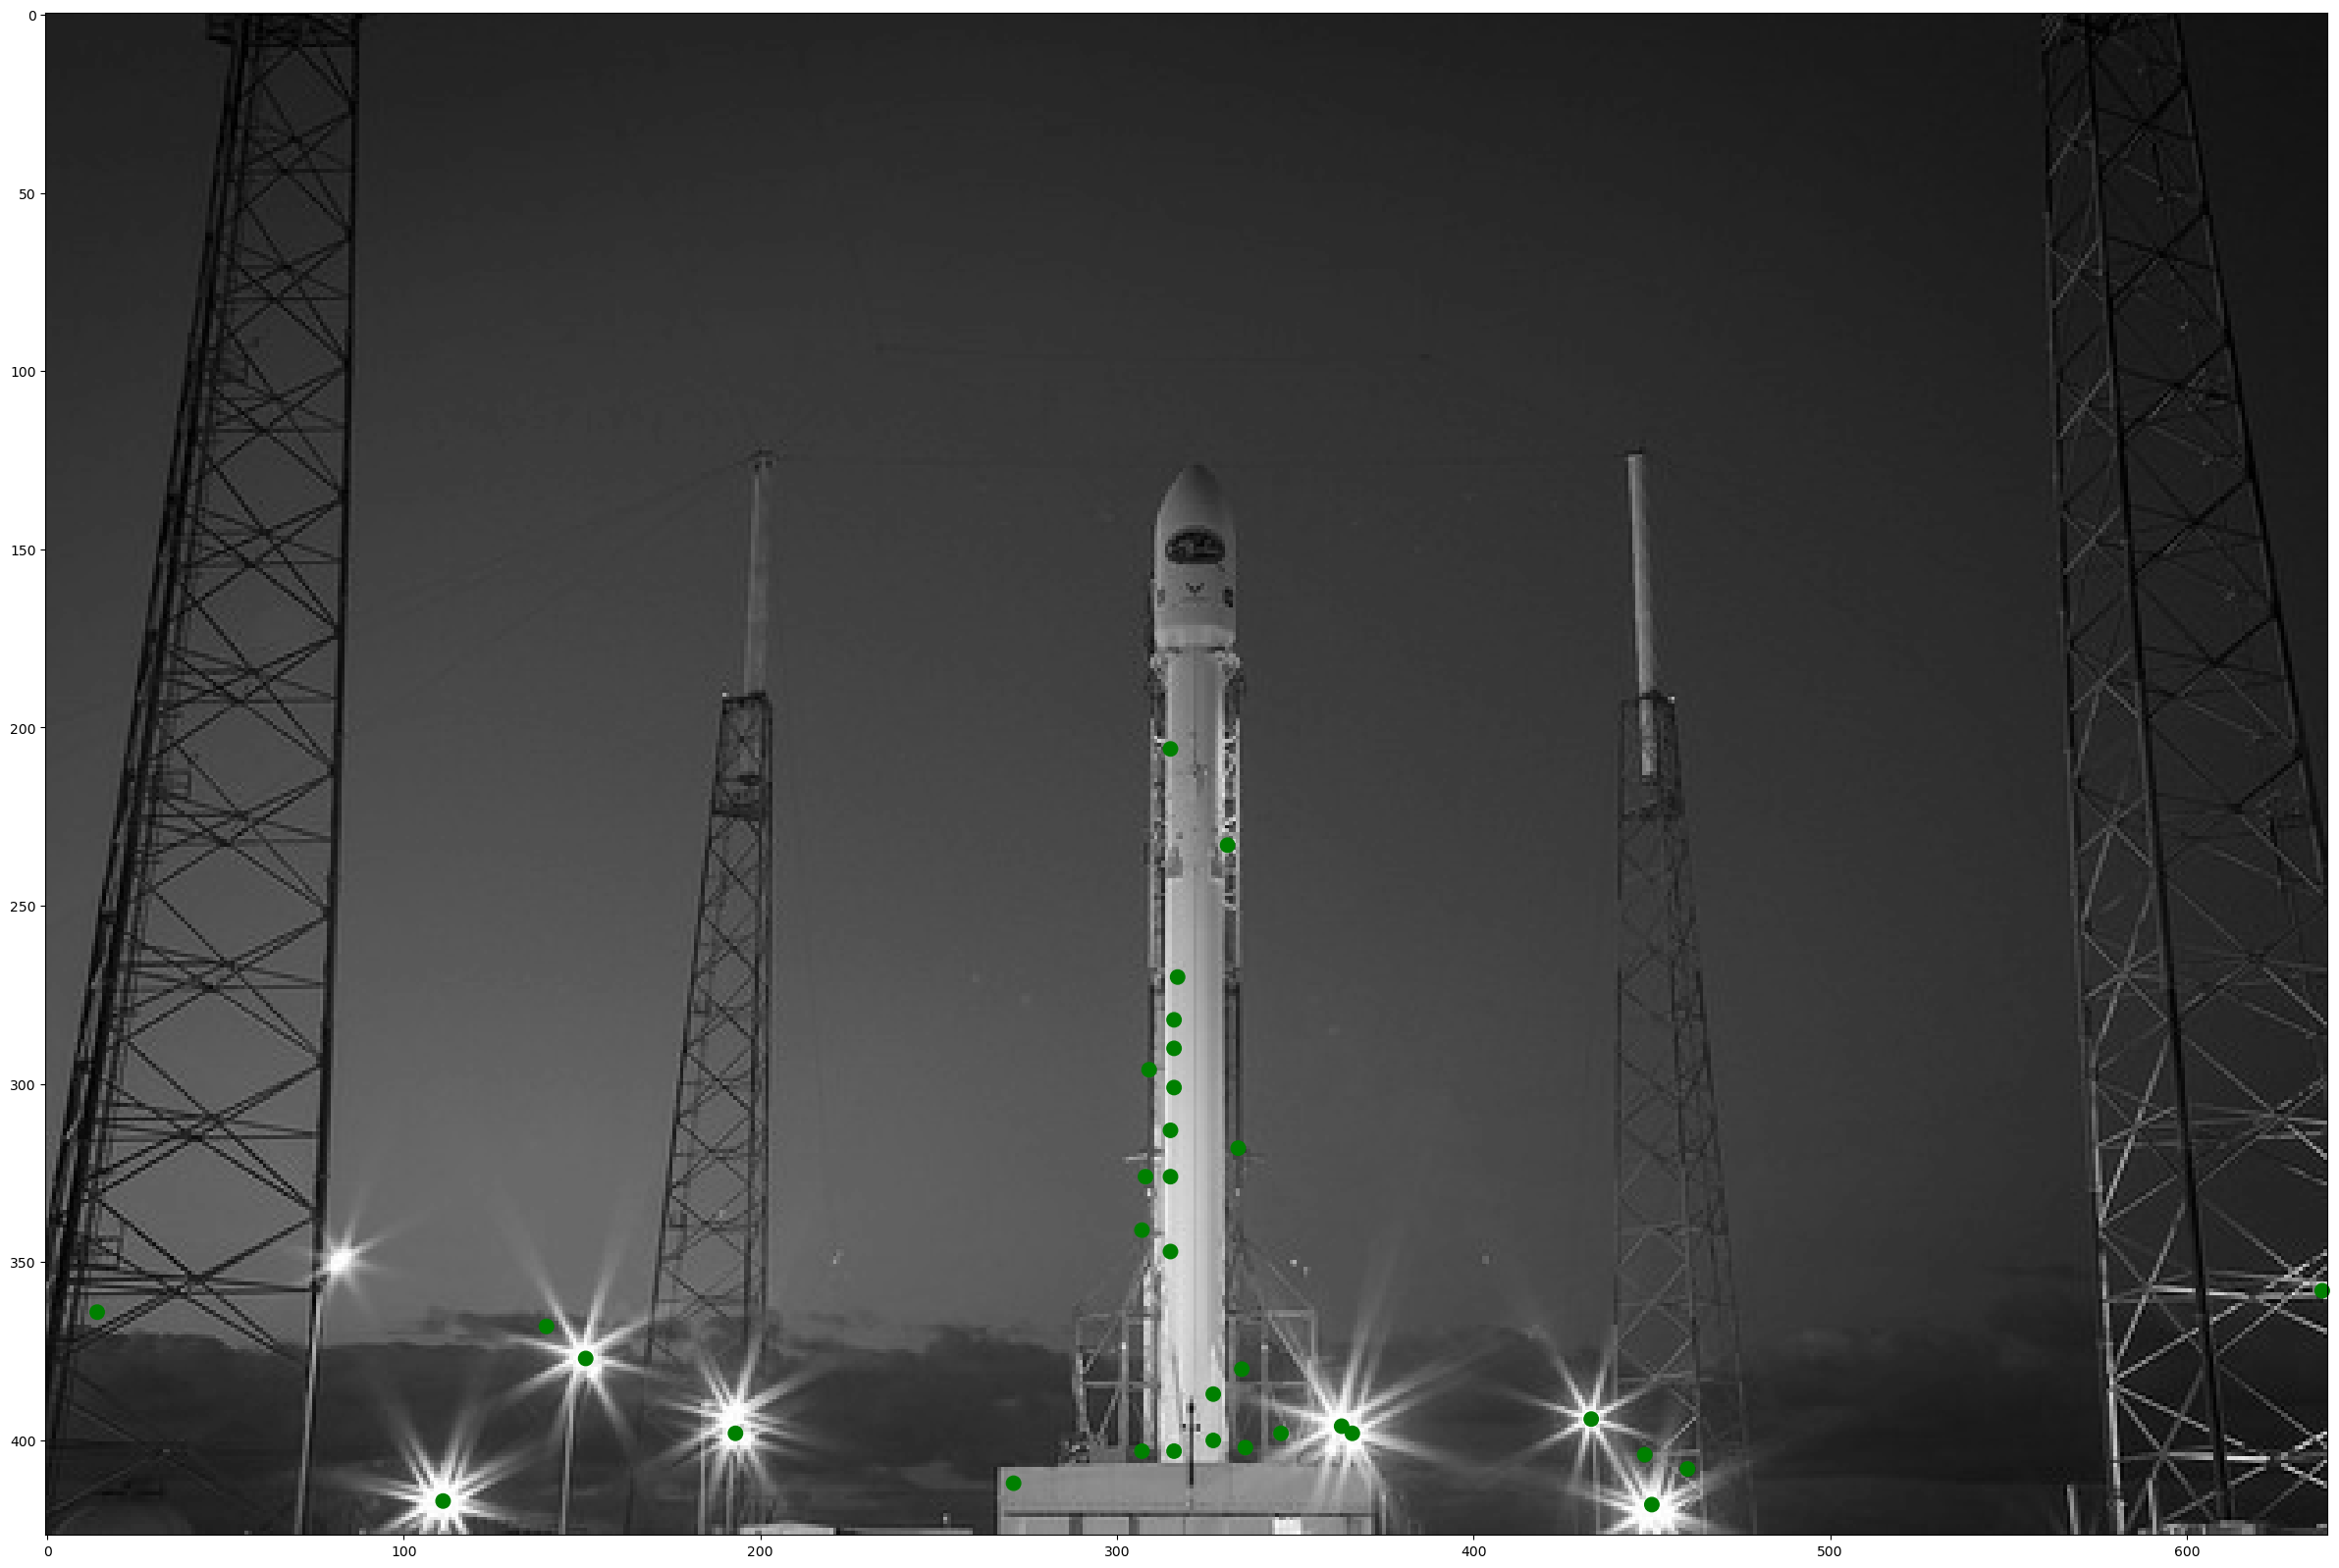

In [111]:
fig, ax = plt.subplots(figsize=(30,30))
rr, cc = np.where(sift.octave_keypoints_global_array[0] *
                  sift.key_point_filter_image_frame(img_shape=img.shape) *
                  sift.key_point_filter_contrast(sift.dog_global_array[0], 0.03) *
                  mask_after_removed_edge_points)
ax.imshow(img, cmap="gray")
for r,c in zip(rr,cc):
    circle1 = plt.Circle((c, r), 2, color='g', clip_on=False)
    ax.add_patch(circle1)

In [112]:
# TODO:
# - Filtering key-points on edges (Eliminating edge responses) refactor to class
# - create filtering for different scales
# - key-point orientation
# - key-point descriptor
# - image matching example